In [46]:
import yfinance as yf
from yfinance import shared
import os
import pandas as pd
from datetime import datetime
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt

In [17]:
SYMBOLS = ['EURUSD=X', 'GBPUSD=X']
START_DATE = "2023-01-01"
END_DATE = datetime.today().strftime("%Y-%m-%d")
CAPITAL = 50000
INTERVALS = ['1d', '1h']

for ticker in SYMBOLS:
	for i in INTERVALS:
		try:
			file_directory = os.getcwd()
			stock_data = yf.download(ticker, start=START_DATE, end=END_DATE, interval=i)
			if ticker in shared._ERRORS:
				stock_data = yf.download(ticker, start=START_DATE, end=END_DATE, interval=i)
			if not os.path.exists('data'):
				os.makedirs('data')
			stock_data.to_csv('data/' + ticker + '_' + i + '.csv')
		except Exception as e:
			print(e)

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [18]:
def GoldenCrossSignal(name, interval):
	path = 'data/' + name + '_' + interval + '.csv'

	index = 'Datetime' # Get rid of this!!!
	if 'h' not in interval:
		index = 'Date'

	stock_data = pd.read_csv(path, parse_dates=[index], index_col=index)
	stock_data['Prev Close'] = stock_data['Close'].shift(1)
	stock_data['SMA 20'] = stock_data['Prev Close'].rolling(20, min_periods=None).mean()
	stock_data['SMA 50'] = stock_data['Prev Close'].rolling(50, min_periods=None).mean()
	stock_data['EMA 20'] = stock_data['Prev Close'].ewm(span=20, adjust=False, min_periods=20).mean()
	stock_data['EMA 50'] = stock_data['Prev Close'].ewm(span=50, adjust=False, min_periods=None).mean()
	stock_data['Signal'] = np.where(stock_data['EMA 20'] > stock_data['EMA 50'], 1, 0)
	stock_data['Position'] = stock_data['Signal'].diff()

	df_pos = stock_data[np.logical_or(stock_data['Position'] == 1, stock_data['Position'] == -1)].copy()
	df_pos['Position'] = df_pos['Position'].map(lambda x: 'Buy' if x == 1 else 'Sell')
	if df_pos.shape[0] <= 1:
		df_pos = pd.DataFrame(columns=df_pos.columns)
	else:
		df_pos = df_pos[np.logical_and(df_pos.index >= df_pos[df_pos['Position'] == 'Buy'].index[0], df_pos.index <= df_pos[df_pos['Position'] == 'Sell'].index[-1])]
	return df_pos

In [19]:
class BackTest:
	def __init__(self):
		self.columns = ['Equity Name', 'Trade', 'Entry Time', 'Entry Price', 'Exit Time', 'Exit Price', 'Exit Type', 'Quantity', 'Position Size', 'PNL', '% PNL', 'Holding Period']
		self.backtesting = pd.DataFrame(columns=self.columns)

	def buy(self, equity_name, entry_time, entry_price, position):
		self.tradelog = dict(zip(self.columns, [None] * len(self.columns)))
		self.tradelog['Equity Name'] = equity_name
		self.tradelog['Trade'] = 'Long Open'
		self.tradelog['Entry Time'] = entry_time
		self.tradelog['Entry Price'] = entry_price
		self.tradelog['Quantity'] = round(position / self.tradelog['Entry Price'], 3)
		self.tradelog['Position Size'] = position

	def sell(self, exit_time, exit_price, exit_type, charge):
		self.tradelog['Trade'] = 'Long Closed'
		self.tradelog['Exit Time'] = exit_time
		self.tradelog['Exit Price'] = exit_price
		self.tradelog['Exit Type'] = exit_type
		self.tradelog['PNL'] = round((self.tradelog['Exit Price'] - self.tradelog['Entry Price']) * self.tradelog['Quantity'] - charge, 3)
		self.tradelog['% PNL'] = round(self.tradelog['PNL'] / self.tradelog['Position Size'] * 100, 3)
		self.tradelog['Holding Period'] = self.tradelog['Exit Time'] - self.tradelog['Entry Time']
		self.backtesting = pd.concat([self.backtesting, pd.DataFrame(self.tradelog, columns=self.columns, index=[0])], axis=0, ignore_index=True)
		return self.tradelog['PNL']

	def stats(self):
		df = self.backtesting
		parameters = ['Total Trade Scripts', 'Total Trade', 'PNL', 'Winners', 'Losers', '% Win Ratio', 'Total Profit', 'Total Loss', 'Average Profit per Trade', 'Average Loss per Trade', 'Average PNL per Trade', 'Risk Reward']
		total_trade_scripts = len(df['Equity Name'].unique())
		total_trade = df.shape[0]
		pnl = round(df['PNL'].sum(), 2)
		winners = df[df['PNL'] > 0].shape[0]
		losers = df[df['PNL'] <= 0].shape[0]
		win_ratio = 0 if total_trade == 0 else round(winners/total_trade * 100, 2)
		total_profit = round(df[df['PNL'] > 0]['PNL'].sum(), 2)
		total_loss = round(df[df['PNL'] <= 0]['PNL'].sum(), 2)
		avg_profit_per_trade = 0 if winners == 0 else round(total_profit/winners, 2)
		avg_loss_per_trade = 0 if losers == 0 else  round(total_loss/losers, 2)
		avg_pnl_per_trade = 0 if total_trade == 0 else  round(pnl/total_trade, 2)
		risk_reward = f'1:{0 if avg_loss_per_trade == 0 else -1 * round(avg_profit_per_trade/avg_loss_per_trade, 2)}'
		data_points = [total_trade_scripts, total_trade, pnl, winners, losers, win_ratio, total_profit, total_loss, avg_profit_per_trade, avg_loss_per_trade, avg_pnl_per_trade, risk_reward]
		data = list(zip(parameters, data_points))
		print(tabulate(data, headers=['Parameters', 'Values'], tablefmt='psql'))

In [20]:
records = []
bts = []

for equity_name in SYMBOLS:
	tmp_records = []
	tmp_bts = []

	for interval in INTERVALS:
		bt = BackTest()
		required_df = GoldenCrossSignal(equity_name, interval)
		position = CAPITAL
		for index, data in required_df.iterrows():
			if data['Position'] == 'Buy':
				bt.buy(equity_name, index, data['Open'], position)
			elif data['Position'] == 'Sell':
				position += bt.sell(index, data['Open'], 'Exit Trigger', 0)
		tmp_records.append(required_df)
		tmp_bts.append(bt)

	records.append(tmp_records)
	bts.append(tmp_bts)

/tmp/ipykernel_23935/80945263.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.backtesting = pd.concat([self.backtesting, pd.DataFrame(self.tradelog, columns=self.columns, index=[0])], axis=0, ignore_index=True)
/tmp/ipykernel_23935/80945263.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.backtesting = pd.concat([self.backtesting, pd.DataFrame(self.tradelog, columns=self.columns, index=[0])], axis=0, ignore_index=True)
/tmp/ipykernel_23935/80945263.py:23: FutureWarning: The be

In [21]:
for i in range(len(SYMBOLS)):
	for j in range(len(INTERVALS)):
		print(SYMBOLS[i], INTERVALS[j], 'Graph')
		bts[i][j].stats()

EURUSD=X 1d Graph
+--------------------------+----------+
| Parameters               | Values   |
|--------------------------+----------|
| Total Trade Scripts      | 1        |
| Total Trade              | 6        |
| PNL                      | -2972.5  |
| Winners                  | 0        |
| Losers                   | 6        |
| % Win Ratio              | 0.0      |
| Total Profit             | 0.0      |
| Total Loss               | -2972.5  |
| Average Profit per Trade | 0        |
| Average Loss per Trade   | -495.42  |
| Average PNL per Trade    | -495.42  |
| Risk Reward              | 1:0.0    |
+--------------------------+----------+
EURUSD=X 1h Graph
+--------------------------+----------+
| Parameters               | Values   |
|--------------------------+----------|
| Total Trade Scripts      | 1        |
| Total Trade              | 104      |
| PNL                      | 131.02   |
| Winners                  | 34       |
| Losers                   | 70       |
| % 

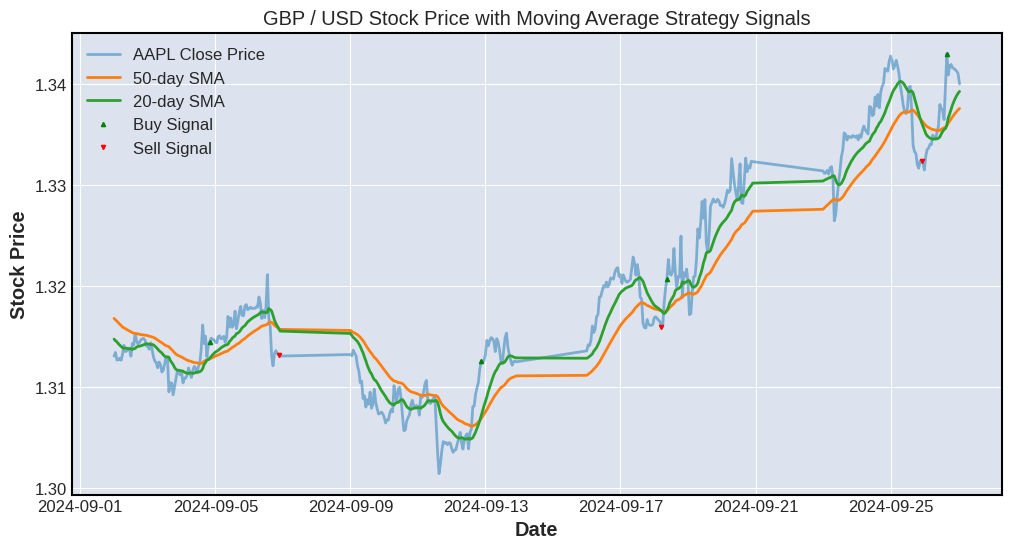

In [54]:
start = '2024-09-01'
end = '2024-09-27'

stock_data = pd.read_csv("data/GBPUSD=X_1h.csv", parse_dates=['Datetime'], index_col='Datetime')
stock_data['Prev Close'] = stock_data['Close'].shift(1)
stock_data['SMA 20'] = stock_data['Prev Close'].rolling(20, min_periods=None).mean()
stock_data['SMA 50'] = stock_data['Prev Close'].rolling(50, min_periods=None).mean()
stock_data['EMA 20'] = stock_data['Prev Close'].ewm(span=20, adjust=False, min_periods=20).mean()
stock_data['EMA 50'] = stock_data['Prev Close'].ewm(span=50, adjust=False, min_periods=None).mean()
stock_data['Signal'] = np.where(stock_data['EMA 20'] > stock_data['EMA 50'], 1, 0)
stock_data['Position'] = stock_data['Signal'].diff()

period = pd.to_datetime([start, end], utc=True)
stock_data = stock_data.loc[period[0]:period[1]]

plt.figure(figsize=(12, 6))
plt.plot(stock_data['Adj Close'], label='AAPL Close Price', alpha=0.5)
plt.plot(stock_data['EMA 50'], label='50-day SMA')
plt.plot(stock_data['EMA 20'], label='20-day SMA')
plt.plot(stock_data.loc[stock_data['Position'] == 1, 'Close'], '^', markersize=3, color='g', label='Buy Signal')
plt.plot(stock_data.loc[stock_data['Position'] == -1, 'Close'], 'v', markersize=3, color='r', label='Sell Signal')
plt.title('GBP / USD Stock Price with Moving Average Strategy Signals')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()